In [1]:
import numpy as np 
import pandas as pd

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
#import lightgbm as lgb
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

import shap
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing & feature generation

In [2]:
data = pd.read_parquet('/kaggle/input/burger-king-churn/train_dataset_hackaton2023_train.gzip')
display(data.sample(5))

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
14639160,23661085,3.0,1,train,179.96,2023-03-28 18:41:32,Гранд Чиз,116.50,Фудкорт с туалетом
17951057,27698595,5.0,1,train,137.99,2022-12-30 12:21:25,Up Капучино (БОЛ.),242.53,Фудкорт без туалета
20076754,30203941,54.0,1,train,149.99,2023-02-19 12:52:17,Айс Твист Шоколадный,110.42,Фудкорт без туалета
11753350,20600471,6.0,1,train,66.00,2022-10-03 16:10:13,Кинг Фри бол,126.60,Фудкорт без туалета
5442231,9465740,36.0,1,train,1.00,2023-01-04 16:17:41,1RUB.Пирожок с вишней,79.70,Фудкорт с туалетом


In [3]:
has_toilet_statuses = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий",
    "Фудкорт с туалетом",
    "Отдельно стоящий с внешн.зоной без туалета",
]

hasnt_toilet_statuses = [
    "Фудкорт без туалета",
    "Отдельно стоящий без внешней зоны без туалета",
    "Отдельно стоящий без туалета",
]

with_external_zone = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий с внешн.зоной без туалета",
]

without_external_zone = [
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий без внешней зоны без туалета",
]

is_foodcourt = [
    "Фудкорт с туалетом",
    "Фудкорт без туалета",
]

proxy_features = [
    'orders_count',
    'monthly_orders_count',
    'last_month_orders_count',
    'dishes_count',
    'ownareaall_sqm'
]

revenue_proxy_features = [
    'revenue',
    'monthly_revenue',
    'last_month_revenue',
]

In [4]:
def preprocess(data, is_train=True):
    
    if is_train:
        data = data[data.format_name != 'Не заполнено']
        #slight date_diff_post aligning
        data.date_diff_post.fillna(-1, inplace=True)
        data.date_diff_post = data.date_diff_post.astype(int)
    
    # make has_toilet column and store there true or false based on has_toilet_statuses
    data['has_toilet'] = data.format_name.isin(has_toilet_statuses)

    # if has external zone then store 2, else 1, if not in with/without_external_zone then store 0
    data['has_external_zone'] = data.format_name.apply(
        lambda x: 2 if x in with_external_zone else 1 if x in without_external_zone else 0
    )

    # 2 - has external zone
    # 1 - hasnt external zone
    # 0 - not defined

    data['is_foodcourt'] = data.format_name.isin(is_foodcourt)

    data.drop('format_name', axis=1, inplace=True)
    
    if is_train:
        # filter outliers in dish_name that have less than 10000 rows
        dish_name_counts = data.dish_name.value_counts()
        dish_name_counts = dish_name_counts[dish_name_counts > 50000]
        data = data[data.dish_name.isin(dish_name_counts.index)]
    
    # create bill_id based on startdatetime and customer_id
    data['bill_id'] = data.groupby(['startdatetime', 'customer_id']).ngroup()
    
    # drop group_name
    data.drop('group_name', axis=1, inplace=True)
    
    # label encode dish_name
    le = LabelEncoder()
    data['dish_name'] = le.fit_transform(data.dish_name)
    
    if is_train:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'date_diff_post': 'first',
            'buy_post': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    else:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    
    data['dish_amount'] = [len(n) for n in data['dish_name']]
    
    #generating even more features!
    # group data by customer_id
    data['dishes_count'] = data.dish_name.apply(lambda x: len(x))
    data['orders_count'] = data.groupby('customer_id')['bill_id'].transform('nunique')

    # count amount of orders for every month
    data['monthly_orders_count'] = data.groupby(['customer_id', data.startdatetime.dt.month])['bill_id'].transform('nunique')
    data['monthly_revenue'] = data.groupby(['customer_id', data.startdatetime.dt.month])['revenue'].transform('sum')

    # get last month
    last_month = data.startdatetime.dt.month.max()
    # get last month orders count
    data['last_month_orders_count'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['bill_id'].transform('nunique')
    # get last month revenue
    data['last_month_revenue'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['revenue'].transform('sum')
    
    #datetime to timestamp
    data['startdatetime'] = [datetime.timestamp(n) for n in data['startdatetime']]
    
    for feature in proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round().astype(int)
    
    for feature in revenue_proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round(2).astype(float)
    
    return data

In [5]:
def group_by_customer(df):
    df = df.groupby('customer_id').agg({
        'customer_id': 'first',

        'revenue': 'mean',
        'monthly_revenue': 'mean',
        'last_month_revenue': 'first',

        'has_toilet': 'sum',
        'has_external_zone': 'sum',
        'is_foodcourt': 'sum',
    
        'orders_count': 'sum',
        'monthly_orders_count': 'mean',
        'last_month_orders_count': 'first',
    
        'ownareaall_sqm': 'mean',
        'dishes_count': 'mean',
        'date_diff_post': 'mean',
        'buy_post': 'first',
    }).reset_index(drop=True)
    
    return df

In [6]:
data = preprocess(data)
data.sample(5)

,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,date_diff_post,buy_post,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue
1157881,1157881,658203,"[30, 5, 41, 4, 21]",1.676069e+09,True,0,False,7,1,314.97,235,5,5,5,3,1258.87,0,0.0
54096,54096,28663545,[11],1.663255e+09,False,0,True,14,1,139.98,88,1,1,13,9,2251.78,0,0.0
95868,95868,29321644,"[32, 47, 20]",1.664131e+09,False,0,True,5,1,319.97,105,3,3,5,2,479.96,0,0.0
2256551,2256551,26562974,"[41, 37]",1.687467e+09,True,0,False,23,1,99.98,421,2,2,3,2,369.97,0,0.0
2418965,2418965,22948491,"[39, 30]",1.690011e+09,True,0,False,16,1,79.99,330,2,2,5,3,319.97,0,0.0


In [7]:
cat_feat = ['has_external_zone', 'has_toilet', 'is_foodcourt']

# Train test split

In [8]:
x = data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]
y = data[['buy_post', 'date_diff_post']]
y_clf = y['buy_post']
y_reg = y['date_diff_post']

x_train, x_test, y_train, y_test = train_test_split(x, y)
y_train_clf, y_test_clf = y_train['buy_post'], y_test['buy_post']
y_train_reg, y_test_reg = y_train['date_diff_post'], y_test['date_diff_post'] 

In [9]:
train_pool_clf = Pool(x_train, y_train_clf, cat_features=cat_feat)
eval_pool_clf = Pool(x_test, y_test_clf, cat_features=cat_feat)
full_train_clf = Pool(x, y_clf, cat_features=cat_feat)

train_pool_reg = Pool(x_train, y_train_reg, cat_features=cat_feat)
eval_pool_reg = Pool(x_test, y_test_reg, cat_features=cat_feat)
full_train_reg = Pool(x, y_reg, cat_features=cat_feat)

# Model training

In [10]:
cbc = CatBoostClassifier(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(train_pool_clf, eval_set=eval_pool_clf)

0:	learn: 0.5566126	test: 0.5574521	best: 0.5574521 (0)	total: 540ms	remaining: 53.4s
1:	learn: 0.4979822	test: 0.4992999	best: 0.4992999 (1)	total: 988ms	remaining: 48.4s
2:	learn: 0.4697738	test: 0.4713314	best: 0.4713314 (2)	total: 1.49s	remaining: 48.1s
3:	learn: 0.4551982	test: 0.4569920	best: 0.4569920 (3)	total: 1.96s	remaining: 47.2s
4:	learn: 0.4472753	test: 0.4492274	best: 0.4492274 (4)	total: 2.36s	remaining: 44.9s
5:	learn: 0.4426405	test: 0.4446624	best: 0.4446624 (5)	total: 2.76s	remaining: 43.2s
6:	learn: 0.4405438	test: 0.4426787	best: 0.4426787 (6)	total: 3.15s	remaining: 41.9s
7:	learn: 0.4386685	test: 0.4408431	best: 0.4408431 (7)	total: 3.56s	remaining: 41s
8:	learn: 0.4377713	test: 0.4399975	best: 0.4399975 (8)	total: 3.98s	remaining: 40.2s
9:	learn: 0.4367827	test: 0.4390526	best: 0.4390526 (9)	total: 4.35s	remaining: 39.1s
10:	learn: 0.4364298	test: 0.4387425	best: 0.4387425 (10)	total: 4.75s	remaining: 38.5s
11:	learn: 0.4360330	test: 0.4383634	best: 0.4383634 (

In [11]:
cbr = CatBoostRegressor(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(train_pool_reg, eval_set=eval_pool_reg)

0:	learn: 15.8275421	test: 15.8395197	best: 15.8395197 (0)	total: 411ms	remaining: 40.7s
1:	learn: 15.7143859	test: 15.7291612	best: 15.7291612 (1)	total: 772ms	remaining: 37.8s
2:	learn: 15.6735642	test: 15.6890581	best: 15.6890581 (2)	total: 1.19s	remaining: 38.6s
3:	learn: 15.6521544	test: 15.6680571	best: 15.6680571 (3)	total: 1.59s	remaining: 38.1s
4:	learn: 15.6418564	test: 15.6579263	best: 15.6579263 (4)	total: 1.92s	remaining: 36.5s
5:	learn: 15.6322211	test: 15.6494575	best: 15.6494575 (5)	total: 2.29s	remaining: 35.9s
6:	learn: 15.6274025	test: 15.6453116	best: 15.6453116 (6)	total: 2.65s	remaining: 35.2s
7:	learn: 15.6206113	test: 15.6393951	best: 15.6393951 (7)	total: 3.03s	remaining: 34.8s
8:	learn: 15.6171263	test: 15.6356827	best: 15.6356827 (8)	total: 3.33s	remaining: 33.7s
9:	learn: 15.6132825	test: 15.6318626	best: 15.6318626 (9)	total: 3.71s	remaining: 33.4s
10:	learn: 15.6108485	test: 15.6296177	best: 15.6296177 (10)	total: 4.08s	remaining: 33s
11:	learn: 15.6077618

In [12]:
'''
parameters = {'depth'         : [8, 10],
              'learning_rate' : [0.3, 0.4],
              'iterations'    : [10, 20],
              'l2_leaf_reg'   : [10, 15, 20]}
              
randomized_search_results = cbc.randomized_search(
    parameters,
    train_pool,
    n_iter=9,
    plot=True
)

randomized_search_results
'''

"\nparameters = {'depth'         : [8, 10],\n              'learning_rate' : [0.3, 0.4],\n              'iterations'    : [10, 20],\n              'l2_leaf_reg'   : [10, 15, 20]}\n              \nrandomized_search_results = cbc.randomized_search(\n    parameters,\n    train_pool,\n    n_iter=9,\n    plot=True\n)\n\nrandomized_search_results\n"

## Making an ansamble

In [13]:
xgbc_train = x_train.copy()
xgbc_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
xgbc_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
xgbc_train['cbr'] = cbr.predict(x_train)
xgbc_train.sample(5)

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
2443009,1.690486e+09,True,1,False,505.97,360,9,9,7,4,1723.88,0,0.00,0.040389,0.959611,14.984663
1289364,1.677435e+09,False,0,True,74.99,62,1,1,18,6,3704.92,0,0.00,0.024710,0.975290,7.211312
149385,1.665004e+09,False,0,False,44.99,261,1,1,30,22,1133.77,0,0.00,0.078597,0.921403,2.201853
2300615,1.687949e+09,True,0,False,103.99,301,2,2,7,3,693.94,0,0.00,0.093320,0.906680,15.870545
822644,1.672406e+09,True,2,False,80.00,303,1,1,3,3,176.68,3,176.68,0.453091,0.546909,14.306794


In [14]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_train, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
'''
krs_train = pd.DataFrame()
krs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]
krs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]
krs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
krs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
krs_train['cbr'] = cbr.predict(x_train)
krs_train.sample(5)
'''

"\nkrs_train = pd.DataFrame()\nkrs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]\nkrs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]\nkrs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]\nkrs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]\nkrs_train['cbr'] = cbr.predict(x_train)\nkrs_train.sample(5)\n"

In [16]:
'''
krs = Sequential()
krs.add(Dense(5, activation='relu', input_shape=(8,)))
krs.add(Dense(5, activation='relu'))
krs.add(Dense(1, activation='sigmoid'))

krs.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

krs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)
'''

"\nkrs = Sequential()\nkrs.add(Dense(5, activation='relu', input_shape=(8,)))\nkrs.add(Dense(5, activation='relu'))\nkrs.add(Dense(1, activation='sigmoid'))\n\nkrs.compile(loss='binary_crossentropy',\n    optimizer='adam',\n    metrics=['accuracy'])\n\nkrs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)\n"

In [17]:
#y_pred = krs.predict_classes(_test)

In [18]:
#from keras.utils import plot_model
#plot_model(model, show_shapes=True)

# Evaluating model

In [19]:
xgbc_test = x_test.copy()
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(x_test)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(x_test)]
xgbc_test['cbr'] = cbr.predict(x_test)
display(xgbc_test.sample(5))

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
505792,1.668871e+09,True,0,True,135.99,104,3,3,3,1,135.99,0,0.00,0.328490,0.671510,18.170785
973430,1.674059e+09,True,1,False,343.98,227,5,5,3,1,343.98,0,0.00,0.300965,0.699035,19.593601
598214,1.669906e+09,True,1,False,124.99,201,2,2,8,6,1512.88,6,1512.88,0.108045,0.891955,18.031504
2081047,1.685723e+09,False,0,True,75.99,117,2,2,12,9,1576.76,0,0.00,0.073540,0.926460,13.396445
240166,1.665949e+09,True,0,False,299.98,235,3,3,11,6,1195.89,0,0.00,0.063768,0.936232,13.985057


In [20]:
print(classification_report(y_test_clf, xgbc.predict(xgbc_test)))

              precision    recall  f1-score   support

           0       0.59      0.14      0.23    126839
           1       0.81      0.97      0.89    489517

    accuracy                           0.80    616356
   macro avg       0.70      0.56      0.56    616356
weighted avg       0.77      0.80      0.75    616356



In [21]:
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['F1'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Precision'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Recall'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Accuracy'][:3])

[0.8847193573951198, 0.8848825390173384, 0.8860526296665044]
[0.8051164613961965, 0.8042630252142956, 0.7977889996352079]
[0.9817902136187303, 0.9834653341967695, 0.9962759209588227]
[0.7967943850631778, 0.7967732933564369, 0.7964877440959446]


In [22]:
print(classification_report(y_test_clf, cbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.59      0.11      0.19    126839
           1       0.81      0.98      0.89    489517

    accuracy                           0.80    616356
   macro avg       0.70      0.55      0.54    616356
weighted avg       0.76      0.80      0.74    616356



In [23]:
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['MAE'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['Poisson'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['RMSE'][:3])

[12.94714329086012, 12.768286280644793, 12.680347831801758]
[12086553.842267655, 21142367.674011137, 29380445.09547997]
[15.839519670716992, 15.729161161648038, 15.689058107422357]


In [24]:
cbc.get_feature_importance()

array([11.72986235,  0.97294925,  0.        ,  1.50800007,  0.8624271 ,
        5.63985222,  0.13589466,  0.87150761, 49.50339954, 24.09043258,
        3.62906318,  0.52479039,  0.53182106])

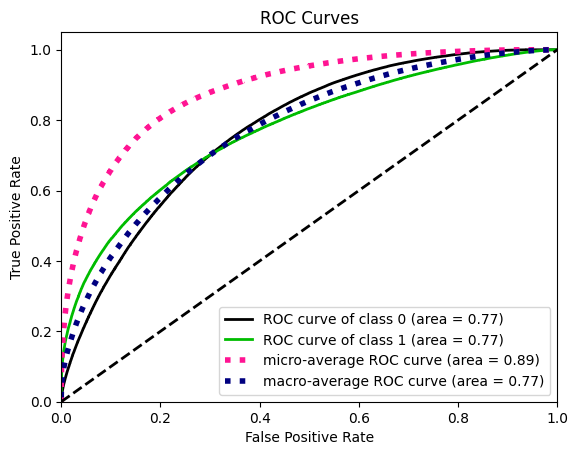

In [25]:
skplt.metrics.plot_roc_curve(y_test_clf, xgbc.predict_proba(xgbc_test))
plt.show()

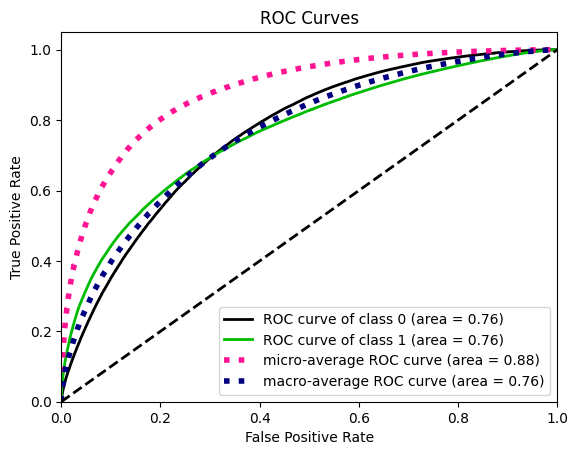

In [26]:
skplt.metrics.plot_roc_curve(y_test_clf, cbc.predict_proba(x_test))
plt.show()

In [27]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(eval_pool_clf)

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [29]:
shap.force_plot(explainer.expected_value, shap_values[0:100,:], x_train.iloc[0:100,:])

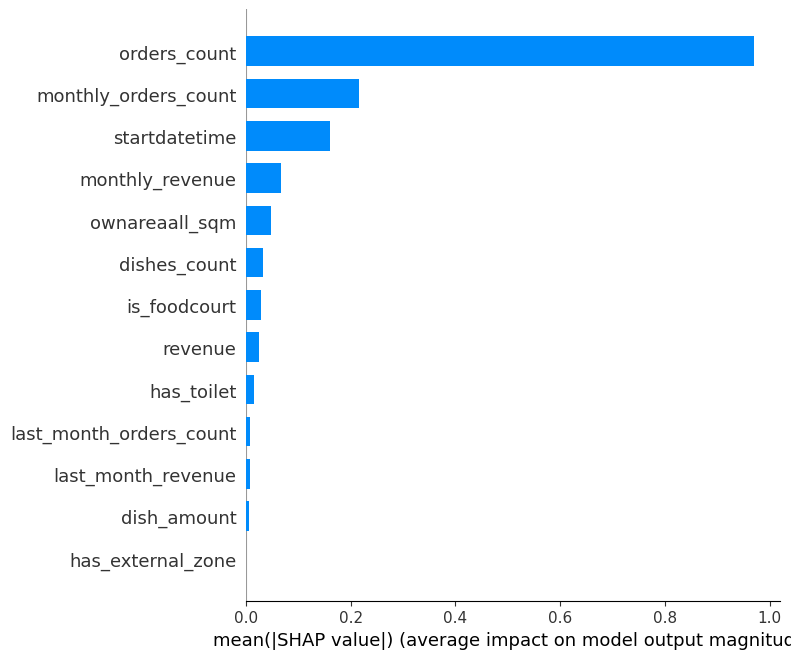

In [30]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

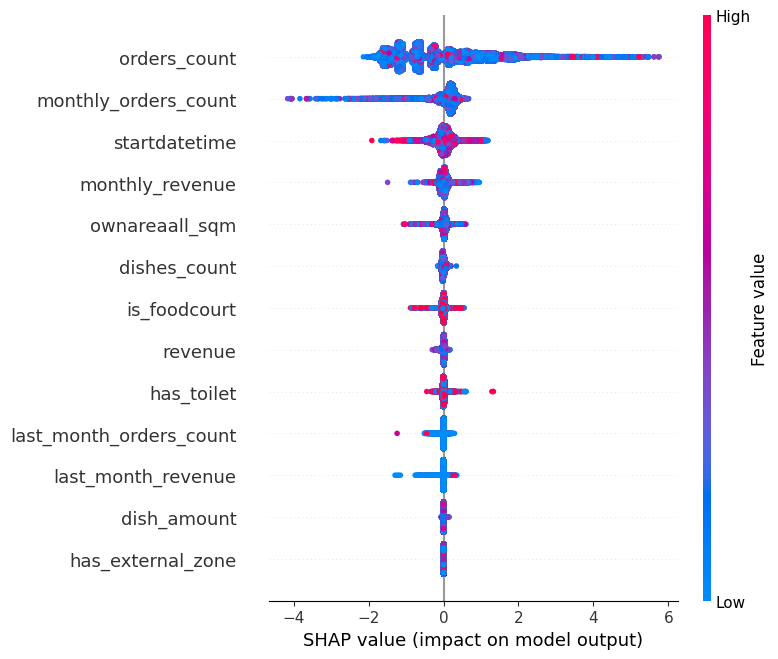

In [31]:
shap.summary_plot(shap_values[:100000], x_train[:100000])

# Train model on the full data

In [32]:
#cbc.load_model('/kaggle/working/cbc')
#cbr.load_model('/kaggle/working/cbc')
#xgbc.load_model('/kaggle/working/xgbc.json')

In [33]:
cbc = CatBoostClassifier()
cbc.fit(full_train_clf, eval_set=eval_pool_clf)

Learning rate set to 0.218125
0:	learn: 0.5835435	test: 0.5839807	best: 0.5839807 (0)	total: 1.28s	remaining: 21m 22s
1:	learn: 0.5234539	test: 0.5242281	best: 0.5242281 (1)	total: 2.64s	remaining: 21m 55s
2:	learn: 0.4903138	test: 0.4913296	best: 0.4913296 (2)	total: 3.79s	remaining: 21m
3:	learn: 0.4727539	test: 0.4739075	best: 0.4739075 (3)	total: 5.08s	remaining: 21m 6s
4:	learn: 0.4608145	test: 0.4620707	best: 0.4620707 (4)	total: 6.37s	remaining: 21m 7s
5:	learn: 0.4533401	test: 0.4546793	best: 0.4546793 (5)	total: 7.5s	remaining: 20m 42s
6:	learn: 0.4496481	test: 0.4510580	best: 0.4510580 (6)	total: 8.71s	remaining: 20m 36s
7:	learn: 0.4463003	test: 0.4477480	best: 0.4477480 (7)	total: 9.85s	remaining: 20m 21s
8:	learn: 0.4445725	test: 0.4460794	best: 0.4460794 (8)	total: 11s	remaining: 20m 8s
9:	learn: 0.4434174	test: 0.4449822	best: 0.4449822 (9)	total: 12.1s	remaining: 19m 56s
10:	learn: 0.4421285	test: 0.4437148	best: 0.4437148 (10)	total: 13.3s	remaining: 19m 53s
11:	learn:

In [34]:
cbr = CatBoostRegressor()
cbr.fit(full_train_reg, eval_set=eval_pool_reg)

Learning rate set to 0.173549
0:	learn: 15.9606679	test: 15.9690010	best: 15.9690010 (0)	total: 762ms	remaining: 12m 40s
1:	learn: 15.8717714	test: 15.8805716	best: 15.8805716 (1)	total: 1.51s	remaining: 12m 33s
2:	learn: 15.8089455	test: 15.8180896	best: 15.8180896 (2)	total: 2.34s	remaining: 12m 58s
3:	learn: 15.7650959	test: 15.7745396	best: 15.7745396 (3)	total: 3.12s	remaining: 12m 57s
4:	learn: 15.7317272	test: 15.7416668	best: 15.7416668 (4)	total: 3.8s	remaining: 12m 36s
5:	learn: 15.7102169	test: 15.7202739	best: 15.7202739 (5)	total: 4.57s	remaining: 12m 37s
6:	learn: 15.6915364	test: 15.7020696	best: 15.7020696 (6)	total: 5.28s	remaining: 12m 29s
7:	learn: 15.6794221	test: 15.6902622	best: 15.6902622 (7)	total: 6.01s	remaining: 12m 25s
8:	learn: 15.6706595	test: 15.6817559	best: 15.6817559 (8)	total: 6.82s	remaining: 12m 31s
9:	learn: 15.6616928	test: 15.6732651	best: 15.6732651 (9)	total: 7.64s	remaining: 12m 36s
10:	learn: 15.6564356	test: 15.6682954	best: 15.6682954 (10)	

In [35]:
xgbc_x = x
xgbc_x['cbc_0'] = [n[0] for n in cbc.predict_proba(x)]
xgbc_x['cbc_1'] = [n[1] for n in cbc.predict_proba(x)]
xgbc_x['cbr'] = cbr.predict(x)
xgbc_x.sample(5)

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
320941,1.666891e+09,False,1,False,579.93,113,7,7,3,2,1049.88,0,0.00,0.264544,0.735456,20.454551
866851,1.672866e+09,True,0,True,566.97,117,5,5,3,2,826.94,0,0.00,0.406737,0.593263,19.397255
620304,1.670170e+09,False,0,True,490.00,112,11,11,4,3,954.96,3,954.96,0.266366,0.733634,20.549257
426890,1.668015e+09,True,0,False,205.99,368,2,2,12,7,1320.93,0,0.00,0.030970,0.969030,13.796010
179968,1.665335e+09,True,2,False,179.98,296,3,3,14,9,1719.85,0,0.00,0.039868,0.960132,12.114787


In [36]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_x, y_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
cbc.save_model('cbc')
cbr.save_model('cbr')
xgbc.save_model('xgbc.json')

# Predicting results

In [38]:
test_data = pd.read_parquet('/kaggle/input/burger-king-churn/hackaton2023_test.gzip')
test_data.sample(5)

,customer_id,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
3309914,25791385,test,1.00,2023-06-18 11:31:14,Луковые Кольца (3 шт.),290.9,Отдельно стоящий
1088140,9434957,test,79.99,2023-05-22 12:06:29,Ord.Сырный и Кисло-сладкий соусы,88.7,Фудкорт без туалета
2457017,21425955,test,239.99,2022-10-03 20:15:14,Чеддер Бекон Ролл,103.4,Фудкорт без туалета
4835813,45097615,test,70.03,2023-06-10 14:07:59,Наггетсы (3 шт.),400.0,Отдельно стоящий с внешней зоной
2412096,21204816,test,44.99,2022-11-10 15:24:41,Соус Сырный,80.0,Фудкорт без туалета


In [39]:
unique = test_data.customer_id.unique()
print(len(unique))
test_data = preprocess(test_data, is_train=False)
print(len(test_data['customer_id'].unique()))
test_data.head()

112334
112334


,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue
0,0,28039329,"[934, 788, 789]",1.662077e+09,False,0,True,1179.96,170,3,3,4,4,3449.86,0,0.0
1,1,33602398,"[599, 81, 611, 282, 803, 860, 561, 860, 544, 8...",1.662078e+09,True,2,False,619.95,307,13,13,3,3,801.93,0,0.0
2,2,28039329,[934],1.662078e+09,False,0,True,289.99,170,1,1,4,4,3449.86,0,0.0
3,3,29250460,"[846, 605, 666, 666, 605, 471, 183, 471, 289, ...",1.662079e+09,True,2,False,828.93,300,13,13,6,5,2609.78,0,0.0
4,4,19197657,[916],1.662080e+09,True,1,False,69.99,338,1,1,3,3,629.95,0,0.0


In [40]:
out = pd.DataFrame()
out['customer_id'] = test_data['customer_id']
test_x = test_data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]

out['date_diff_post'] = cbr.predict(test_x)
xgbc_test = test_x
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(test_x)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(test_x)]
xgbc_test['cbr'] = cbr.predict(test_x)
out['buy_post'] = xgbc.predict(xgbc_test)

print(out.dtypes)
out.head()

customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,28039329,13.026924,0
1,33602398,11.956635,0
2,28039329,14.121220,0
3,29250460,18.485373,1
4,19197657,9.794989,0


In [41]:
#aggregate predictions for paychecks to formulate a prediction for a single user
out = out.groupby('customer_id', as_index=False).mean().round(0)
out['date_diff_post'] = out['date_diff_post'].astype(int)
out['buy_post'] = out['buy_post'].astype(int)

for n, val in enumerate(out['buy_post']):
    if val == 0:
        out['date_diff_post'][n] = None
        
print(len(out.customer_id.unique()))
print(out.dtypes)
out.head()

112334
customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,52341,21.0,1
1,69175,14.0,1
2,73427,4.0,1
3,134577,NaN,0
4,156357,19.0,1


In [42]:
out.to_csv('/kaggle/working/solution.csv', sep=';')